In [ ]:
!pip install prettyprinter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#reading necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.preprocessing import *
from prettyprinter import pprint
from datetime import datetime
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [ ]:
#reading data
listings_df = pd.read_csv("/content/drive/MyDrive/Udacity/boston_airbnb/data/listings.csv")
calendar_df = pd.read_csv("/content/drive/MyDrive/Udacity/boston_airbnb/data/calendar.csv")
reviews_df = pd.read_csv("/content/drive/MyDrive/Udacity/boston_airbnb/data/reviews.csv")


## Business
Airbnb, Inc. is an American company that operates an online marketplace for lodging, primarily home stays for vacation rentals, and tourism activities. Based in San Francisco, California, the platform is accessible via website and mobile app. 
Airbnb is used by millions of host and travelers to list their space and book accommodations anywhere in the world.


## Data Understanding and Preparation
The Boston Airbnb data set consist of three different comma separated value files:<br><br>
listings.csv, including full descriptions and average review score<br>
calendar.csv, including listing id and the price and availability for that day <br>
reviews.csv, including unique id for each reviewer and detailed comments <br>
This analysis will use only the first file, listings.csv. <br>


### Data Cleaning

In [ ]:
#Remove columns with all null values
listings_df = listings_df.dropna(axis=1,how='all')
#remove columns with 

In [ ]:
#selecting meaningful columns based on business understanding
col_list = ['id','host_since','host_response_time','host_response_rate',
            'host_acceptance_rate','host_is_superhost',
            'host_total_listings_count','neighbourhood_cleansed','property_type',
            'room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities',
            'square_feet','price','weekly_price','monthly_price','security_deposit','cleaning_fee',
            'guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating']
listings_df = listings_df[col_list]

In [ ]:
#remove rows with NAN ratings
listings_df = listings_df.dropna(subset=['review_scores_rating'],axis=0)

In [ ]:
#clean text columns
def clean_text(row):
  """
  This function cleans numeric text and returns into converted float values
  InputType:
    pandas.series row
  ReturnType:
    pandas.series row
  """
  list_cols = ['host_response_rate','host_acceptance_rate','cleaning_fee','extra_people',
               'price','weekly_price','monthly_price']
  for col in list_cols:
    try:
      row[col] = float(re.sub('[^0-9 \n\.]','',row[col]))
    except:
      pass
  return row

listings_df = listings_df.apply(lambda row: clean_text(row),axis=1)

#fill nan values with appropriate weekly/monthly price

listings_df['weekly_price'].fillna(listings_df['price']*7,axis=0,inplace=True)
listings_df['monthly_price'].fillna(listings_df['price']*30,axis=0,inplace=True)
listings_df['cleaning_fee'].fillna(0.0,axis=0,inplace=True)

#create a discount column based on weekly and monthly price
def has_discount(row):
  """
  This function creates a one hot encoded discount price column based on daily, weekly and monthly
  price.
  InputType:
    pandas.series row
  ReturnType:
    Int: Discount = 0 or discount=1
  """
  discount = 0 
  price = row['price']
  weekly_price = row['weekly_price']
  monthly_price = row['monthly_price']
  if price * 7 > weekly_price or price * 30 > monthly_price:
    discount = 1
  return discount

#calculate discount
listings_df['discount'] = listings_df.apply(lambda row: has_discount(row), axis=1,result_type='expand')

#drop columns with more than 50% nulls 
listings_df.dropna(axis=1,thresh = listings_df.shape[0]/2,inplace=True)


### Handle Categorical Data

In [ ]:
#check max size for dense encoding of amenities
all_amenities = []
for row in listings_df['amenities']:
  list_amenities = [re.sub('[^a-zA-Z \n\.]','',x) for x in row.split(',')]
  for val in list_amenities:
    all_amenities.append(val)
all_amenities = list(set(all_amenities))
all_amenities.remove('')
all_amenities.remove('translation missing en.hostingamenity')
pprint(all_amenities)
for idx,row in enumerate(listings_df['amenities']):
  list_amenities = [re.sub('[^a-zA-Z \n\.]','',x) for x in row.split(',')]
  listings_df['amenities'].iloc[idx]= list_amenities
mlb = MultiLabelBinarizer()
listings_df = listings_df.join(pd.DataFrame(mlb.fit_transform(listings_df.pop('amenities')),
                          columns=mlb.classes_,
                          index=listings_df.index))
listings_df.drop(columns=['','translation missing en.hostingamenity'],inplace=True)
#creating instance of labelencoder for other categorical columns
cols_to_encode = ['host_is_superhost','host_response_time','neighbourhood_cleansed','property_type','room_type','bed_type']
listings_df[cols_to_encode] = listings_df[cols_to_encode].apply(LabelEncoder().fit_transform)
#getting number of days as a host from current date
listings_df['today'] = datetime.today()
listings_df['host_since'] = (listings_df['today'] - pd.to_datetime(listings_df['host_since'], format="%Y/%m/%d")).dt.days
listings_df.drop(columns=['today','id'],inplace=True)

### Answering Business Questions

#### Q1. Which Neighbourhoods are popular to live amongst customers coming to boston?


*   Based on number of listings in the neighbourhood
*   Based on average ratings given
*   Based on number of reviews





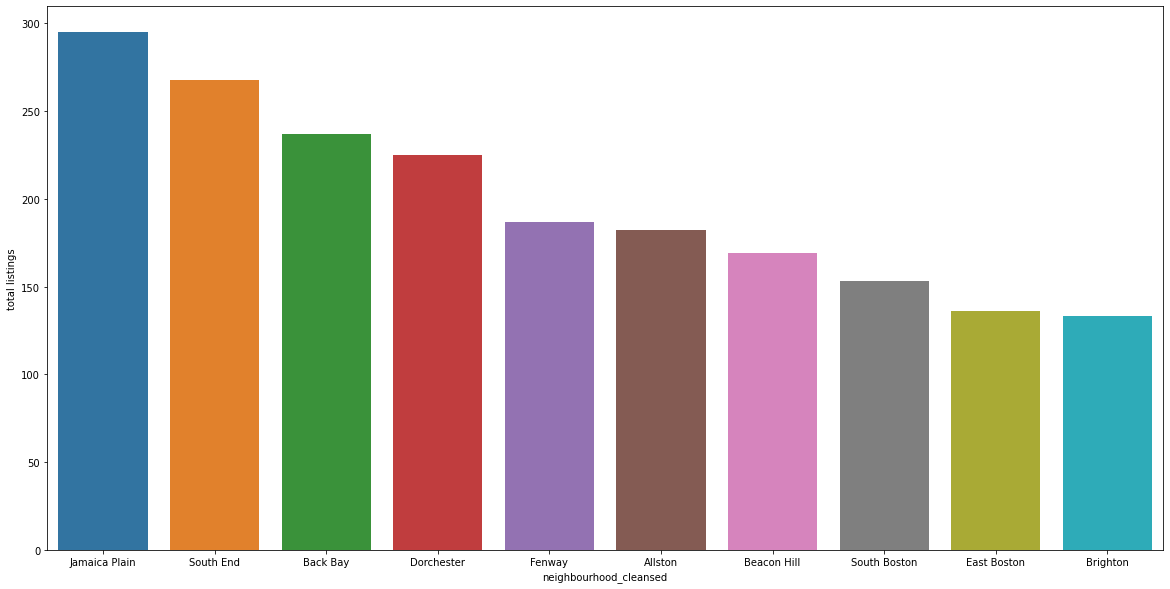

In [ ]:

plot_dt = listings_df.groupby('neighbourhood_cleansed').agg({
    'neighbourhood_cleansed':'count','review_scores_rating':'mean','number_of_reviews':'sum'
}).rename(columns = {'neighbourhood_cleansed':'total listings','review_scores_rating':
                     'average ratings'}).reset_index()
df_1 = plot_dt.sort_values(by='total listings',ascending=False).reset_index(drop=True)[:10]
plt.figure(figsize=(20,10))
sns.barplot(x = df_1['neighbourhood_cleansed'],
            y = df_1['total listings'])
plt.show()

In above output, we assume that the number of listings is correlated to having more popularity. 
We can see that most listings come from Jamaica Plain, followed by South End. Geographically, these are atleast 30 mins drive from Boston downtown which tells us a story that most Airbnb owners live a considerable distance from downtown due to heavy property prices.

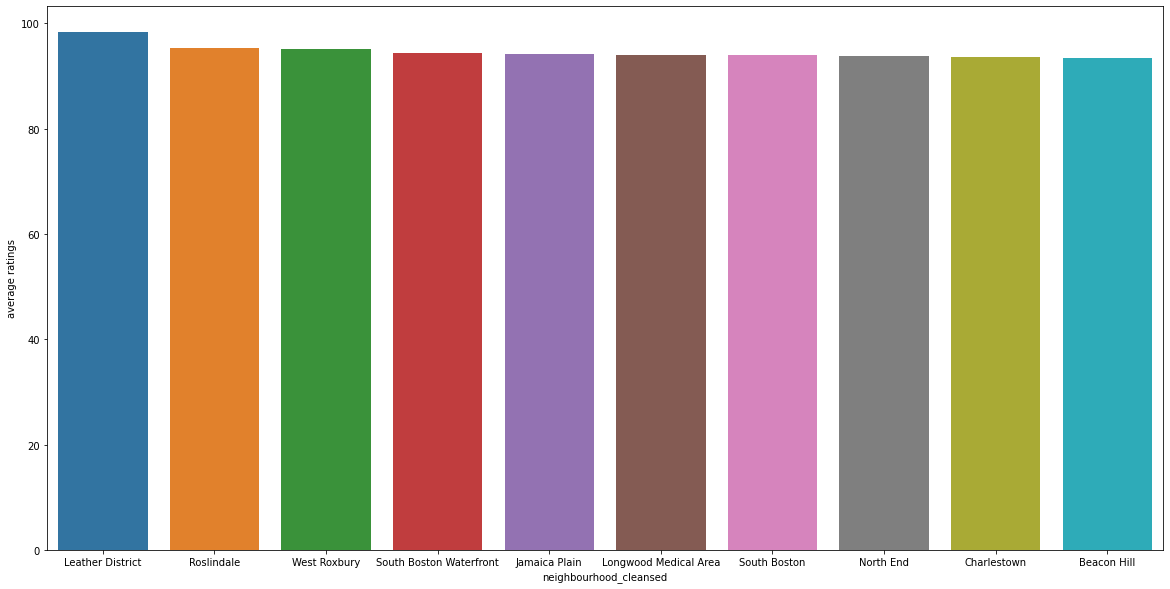

In [ ]:
plt.figure(figsize=(20,10))
df_2 = plot_dt.sort_values(by='average ratings',ascending=False).reset_index(drop=True)[:10]
sns.barplot(x = df_2['neighbourhood_cleansed'],
            y = df_2['average ratings'])
plt.show()

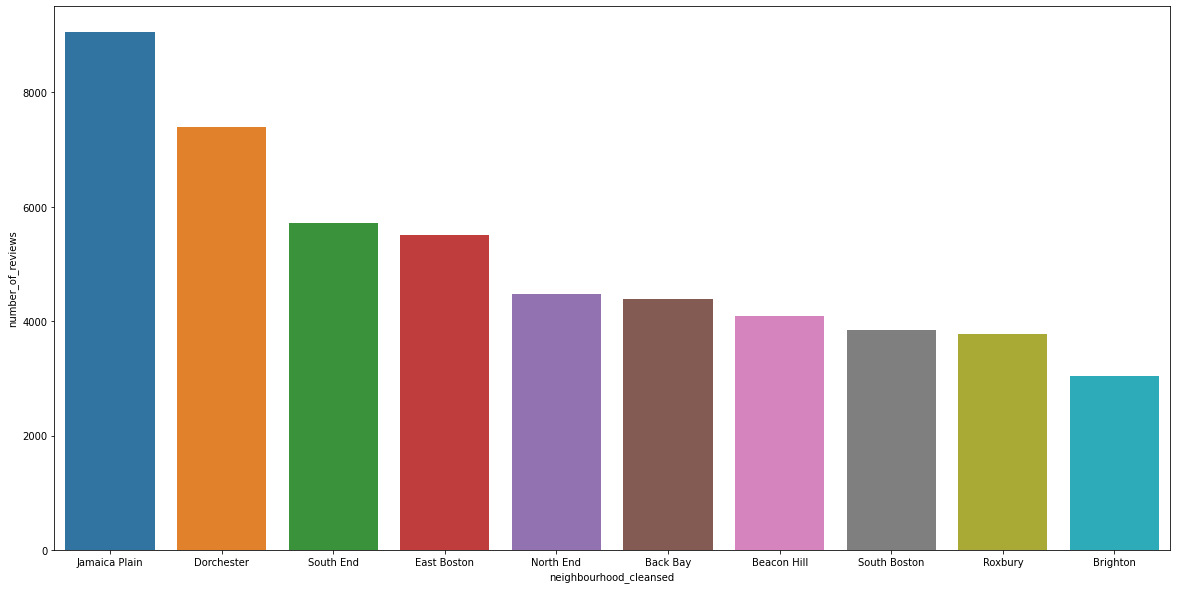

In [ ]:
plt.figure(figsize=(20,10))
df_3 = plot_dt.sort_values(by='number_of_reviews',ascending=False).reset_index(drop=True)[:10]
sns.barplot(x = df_3['neighbourhood_cleansed'],
            y = df_3['number_of_reviews'])
plt.show()

Looking at Average customer ratings, we can see that Jamaica Plain is now at a 5th position with Leather District and Roslindale on top. But, the average can be deceiving as neighborhoods with less number of listings can show higher average ratings. Thus in the next step, we combine averages with counts by performing weighted average over each neighborhood.

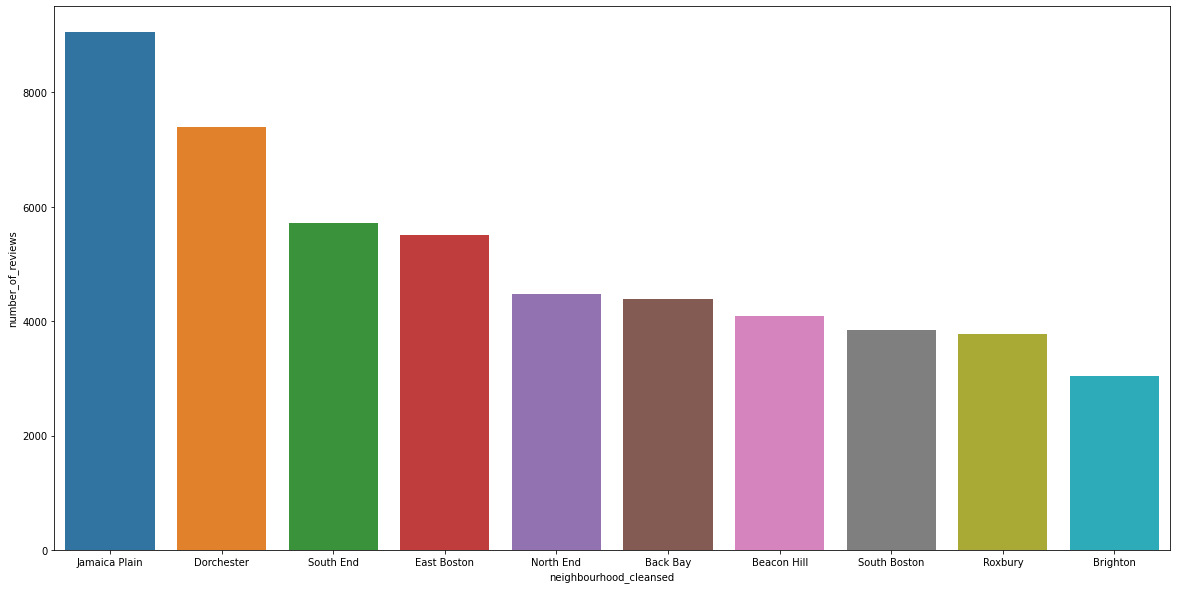

In [ ]:
#combining average ratings with number of reviews
plt.figure(figsize=(20,10))
plot_dt['combined_reviews'] = plot_dt['number_of_reviews'] * plot_dt['average ratings']
df_4 = plot_dt.sort_values(by='combined_reviews',ascending=False).reset_index(drop=True)[:10]
sns.barplot(x = df_4['neighbourhood_cleansed'],
            y = df_4['number_of_reviews'])
plt.show()

This provides us with intuitively correct results with Jamaica Plain still at the top position but the Dorchester area has higher listings as well as higher ratings than the South End region.

#### Q2: Types of Airbnbs offered in boston


*   Whats the popular property type that gets posted?



In [ ]:
listings_df[['property_type','room_type']]

,property_type,room_type
1,Apartment,Private room
2,Apartment,Private room
3,House,Private room
4,House,Private room
5,Condominium,Private room
...,...,...
3574,Townhouse,Private room
3575,Apartment,Private room
3578,House,Private room
3580,Apartment,Private room


In [ ]:
listings_df['room_type'].value_counts()

Entire home/apt    1641
Private room       1078
Shared room          53
Name: room_type, dtype: int64

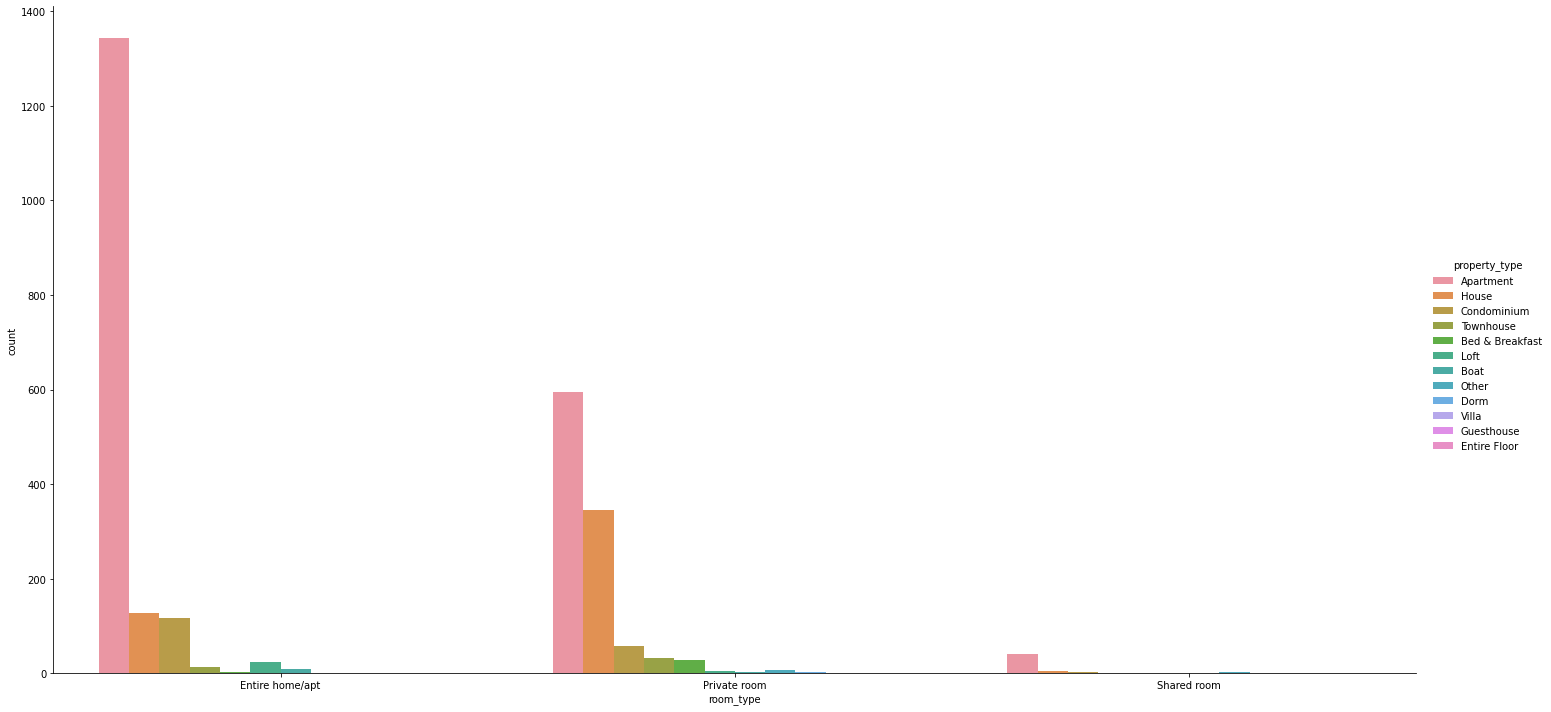

In [ ]:
plot_dt_1 = listings_df.groupby(['property_type','room_type']).agg({'id':'count'}).rename(columns = {'id':'count'}).sort_values(by='count',ascending=False).reset_index()
sns.catplot(x = 'room_type', y='count', 
            hue = 'property_type',data=plot_dt_1, kind='bar', height=10, aspect=20/10)
plt.show()

 entire home/apt room types are more common in apartment listings rather than a house, townhouse, or condo. This is can be due to multiple factors such as popularity amongst tourists, cost of the property, etc.

#### Q3: What factors affect ratings the most?


*   can we predict ratings given to an airbnb listing based on different factors identified?



Due to dimensionality of the data and available number of features we will fit a random forest regressor to predict rating

In [ ]:
listings_df.dropna(how='any',axis = 0,inplace=True)

In [ ]:
x = listings_df.drop('review_scores_rating', axis = 1) # Features
y = listings_df['review_scores_rating']  # Target
# Splitting the dataset into training and testing set (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 28)
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)
# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)
# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  0.8953


Plotting the feature importances in random forest

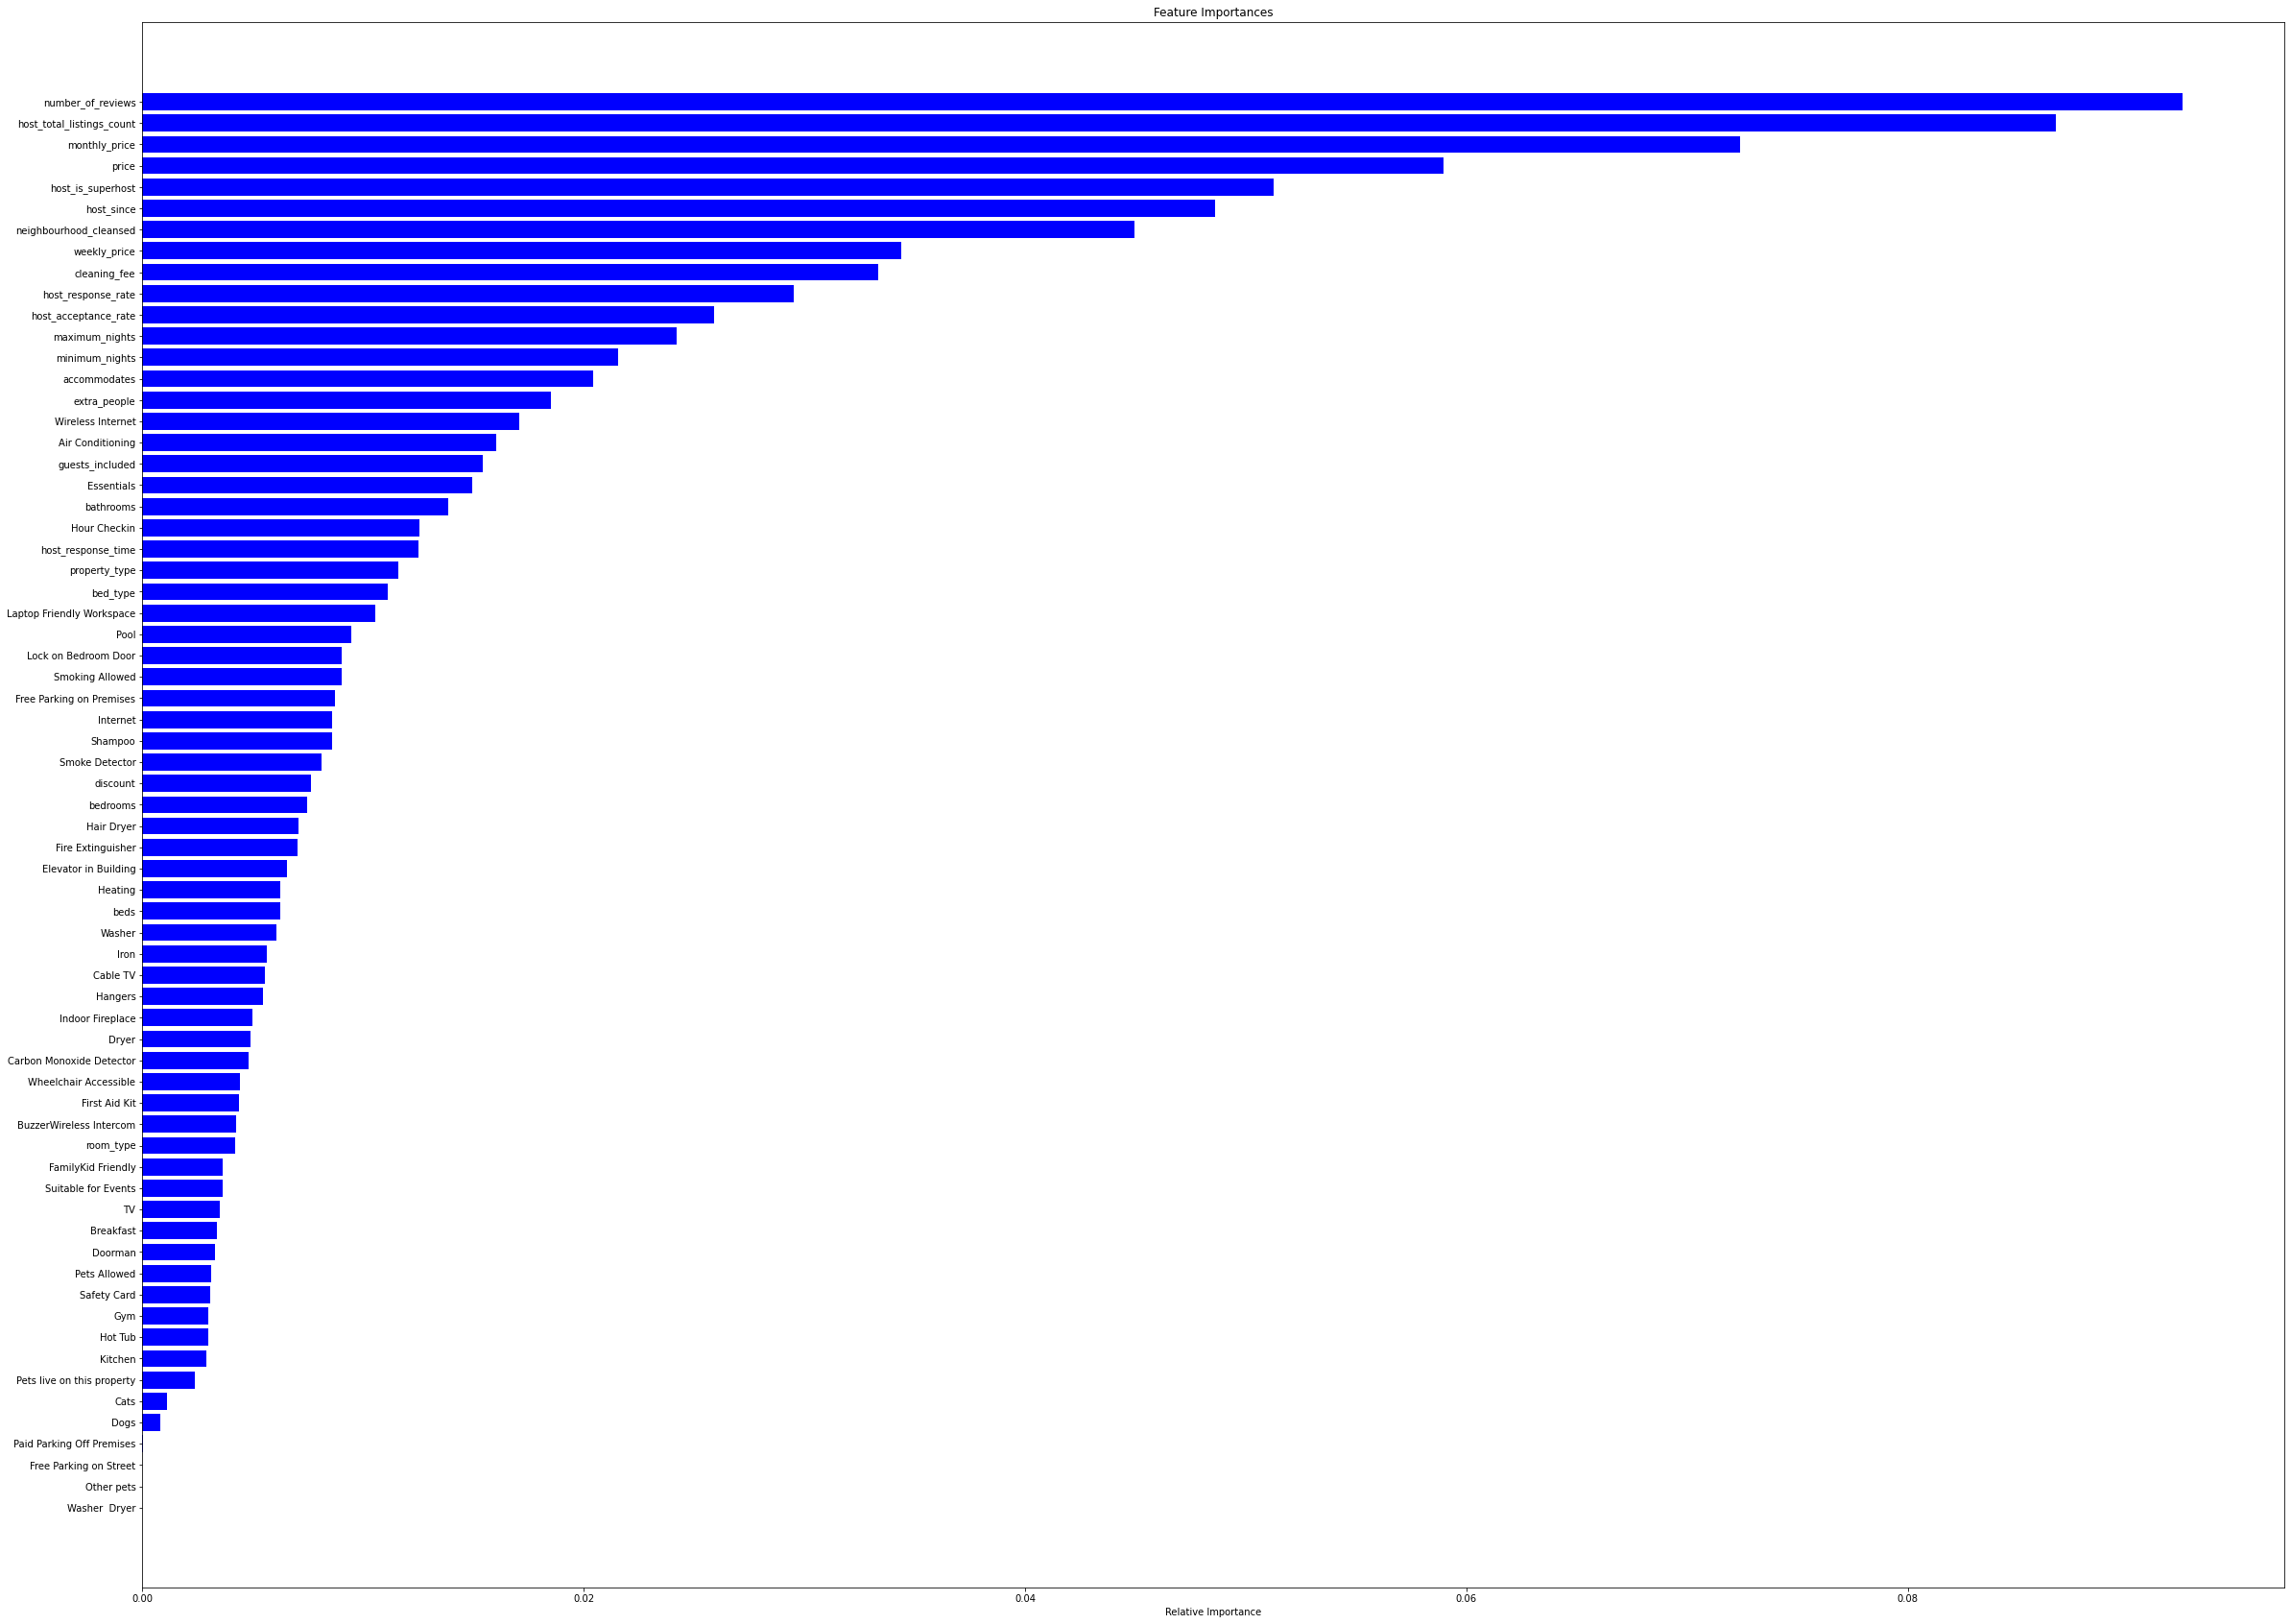

In [ ]:
features = x.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(40,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From percentage correlation I can see that not much correlation exist for the response variable “customer ratings” , where the top feature “number of reviews” getting correlation score of 0.08
